In [2]:
%%HTML
<style> code {background-color : pink !important;} </style>

In [3]:
import cv2
import glob
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

### camera calibration

In [ ]:
# create obj points 
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# lists of objpoints and image points from images
objpoints = []
imgpoints = []

# list of calibration images
calib_imgs = glob.glob('camera_cal/calibration*.jpg')
# print(len(calib_imgs))

# iterate over images and search for chessboard corners
for idx, fname in enumerate(calib_imgs):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # if found, add object points and image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
#         print(len(corners))
        # show corners on image
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)
        
cv2.destroyAllWindows()

In [4]:
%matplotlib inline

In [ ]:
# Test undistortion on an image
cal_img = cv2.imread(calib_imgs[2])
cal_img_size = (cal_img.shape[1], cal_img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, cal_img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "car_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

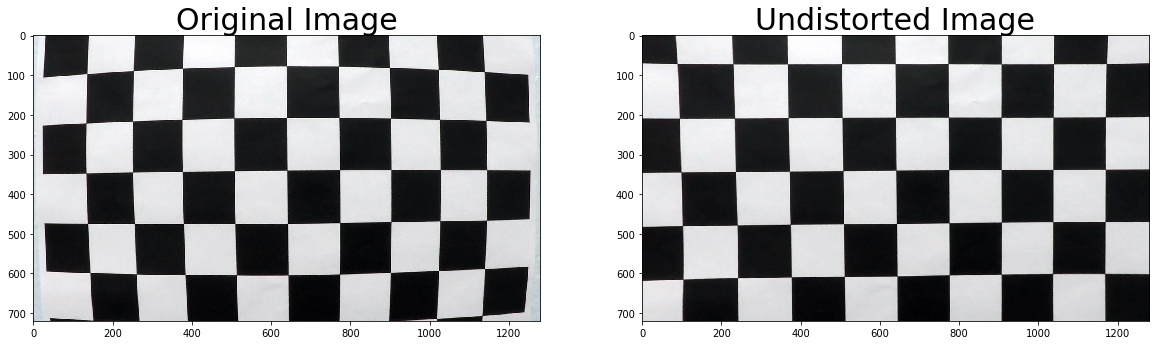

In [5]:
# if we already have pickle with cam matrix and distortion coefficients
# run only this cell
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()

dist_pickle = pickle.load( open( "car_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

calib_imgs = glob.glob('camera_cal/calibration*.jpg')
cal_img = cv2.imread(calib_imgs[1])
dst = cv2.undistort(cal_img, mtx, dist, None, mtx)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cal_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig("distUndist.png")

### load images

In [6]:
# prepare list of test images
test_img_dir = "test_images"
# test_img_dir = "short_test_images"
# test_img_dir = "hard_test_images"
test_img_list = os.listdir(test_img_dir)
test_images = []
for i in range(len(test_img_list)):
    img_path = os.path.join(test_img_dir, test_img_list[i])
    test_images.append(mpimg.imread(img_path))

### perspective transform 

In [ ]:
# use interactive window to find points for perspective pransform
und_test_img = cv2.undistort(test_images[0], mtx, dist, None, mtx)
cv2.imshow("undist st_test image", und_test_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
img = mpimg.imread(os.path.join("test_images", test_images[0]))
plt.imshow(img)

In [7]:
def show_batch(img_list):
    fig = plt.figure(figsize=(20, 20))
    for i in range(len(img_list)):
        fig.add_subplot(4, 2, i+1)
        plt.imshow(img_list[i])
    plt.show()

def show_batch_grey(img_list):
    fig = plt.figure(figsize=(20, 20))
    for i in range(len(img_list)):
        fig.add_subplot(4, 2, i+1)
        plt.imshow(img_list[i], cmap='gray')
    plt.show()
    
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def undist(img, mtx, dist):
    und_img = cv2.undistort(img, mtx, dist, None, mtx)
    return und_img

def warp_undistorted(img):
    img_size = (img.shape[1], img.shape[0])
    # Source points - defined area of lane line edges
    src = np.float32([[690,450],[1110,img_size[1]],[175,img_size[1]],[595,450]])
    # 4 destination points to transfer
    offset = 300 # offset for dst points
    dst = np.float32([[img_size[0]-offset, 0],[img_size[0]-offset, img_size[1]],
                      [offset, img_size[1]],[offset, 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)

    return warped, M

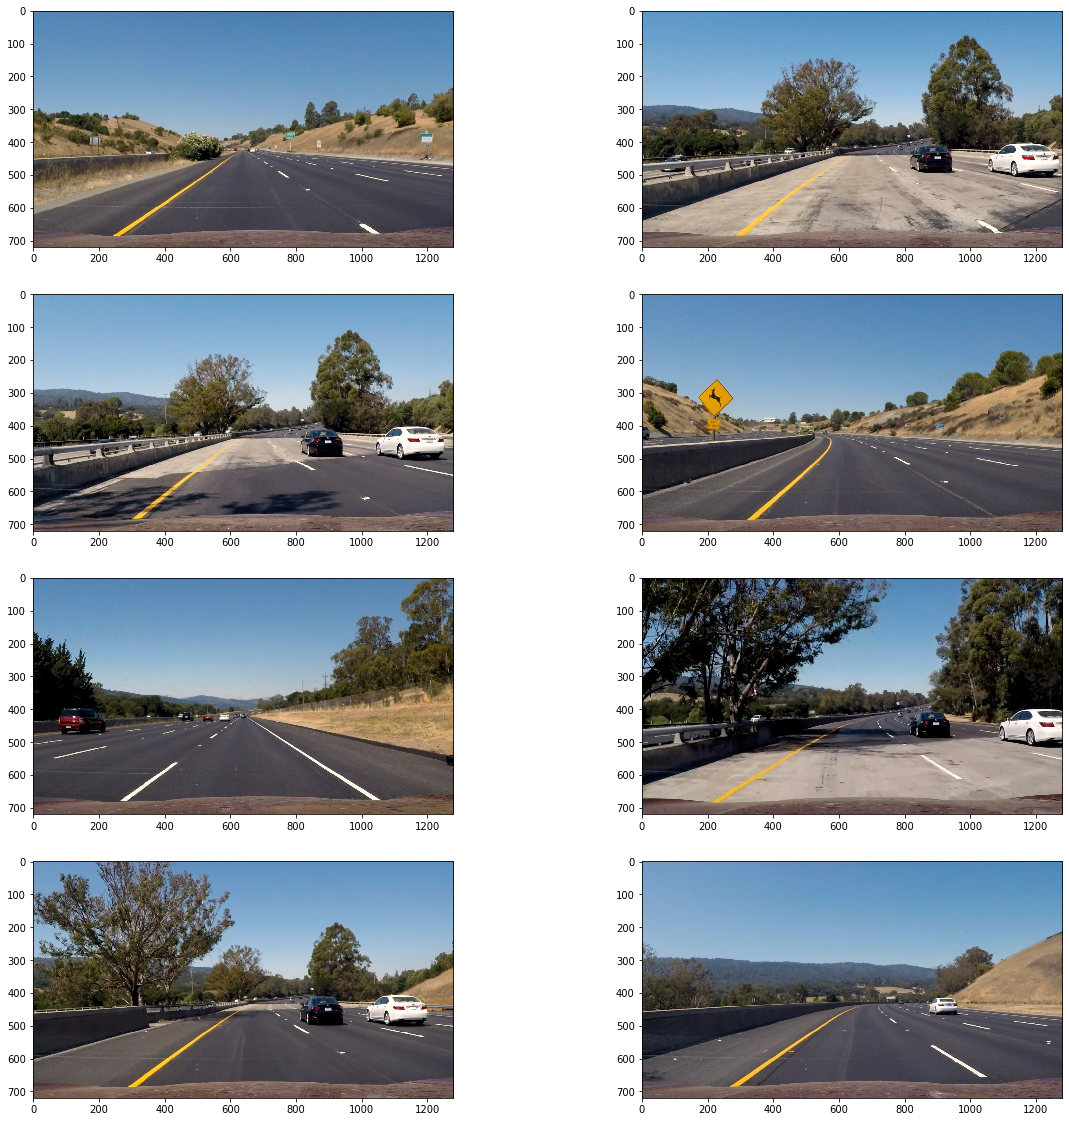

In [7]:
show_batch(test_images)

In [ ]:
cal_img = test_images[0]
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cal_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(udist_list[0])
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig("realDistUndist.png")

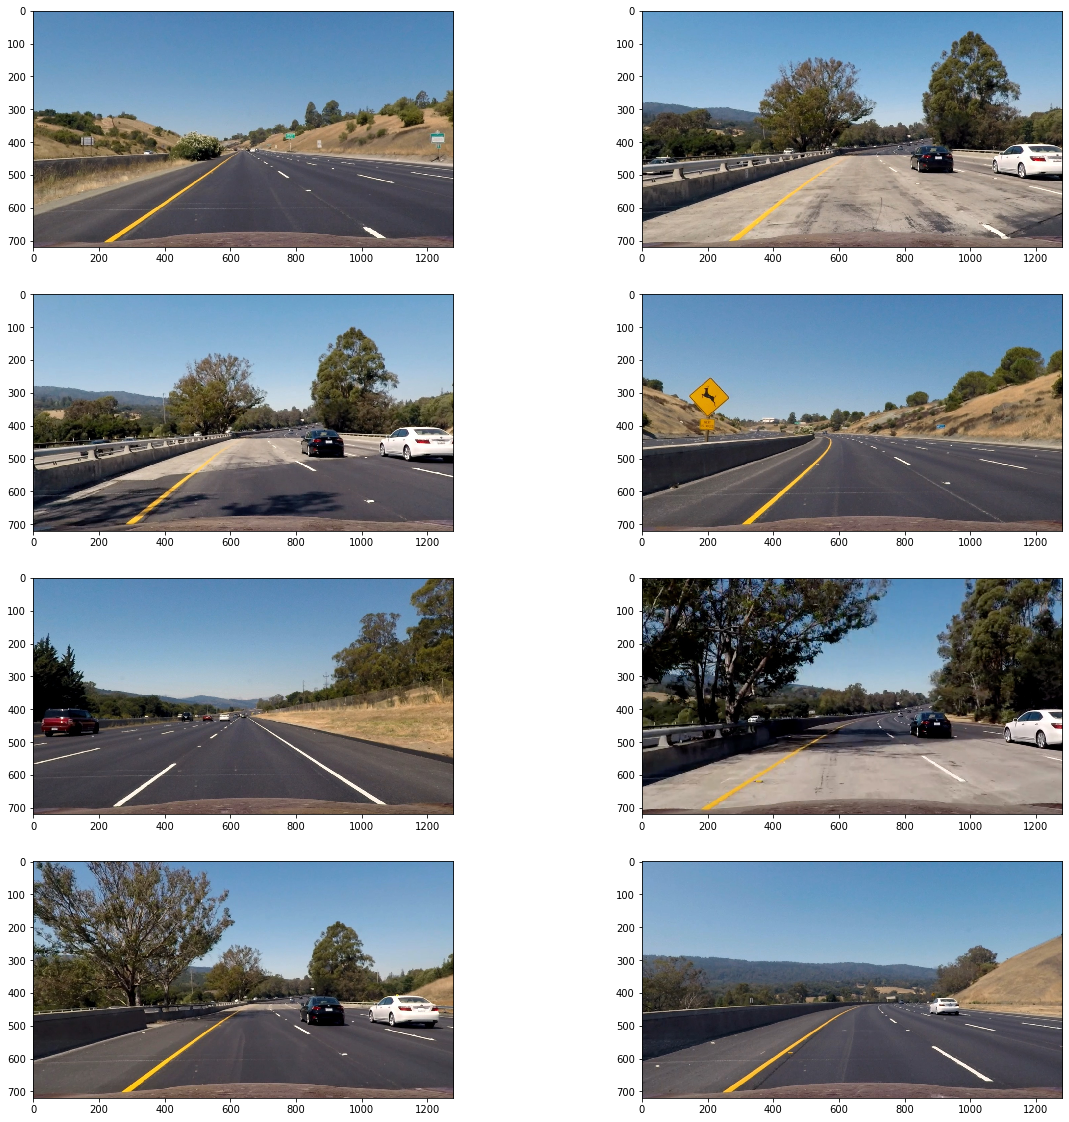

In [8]:
# undistort images
udist_list = []
for i in range(len(test_images)):
    undisted = undist(test_images[i], mtx, dist)
    udist_list.append(undisted)
show_batch(udist_list)

### finding threshold

In [9]:
# define color threshold functions
def s_hsl_thresh(img, s_thresh=(0, 255)):
    img = np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel < s_thresh[1])] = 1
    
    return s_binary

def s_hsv_thresh(img, s_thresh=(0, 255)):
    img = np.copy(img)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    s_channel = hsv[:,:,1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel < s_thresh[1])] = 1
    
    return s_binary

def v_hsv_thresh(img, v_thresh=(0, 255)):
    img = np.copy(img)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel < v_thresh[1])] = 1
    
    return v_binary

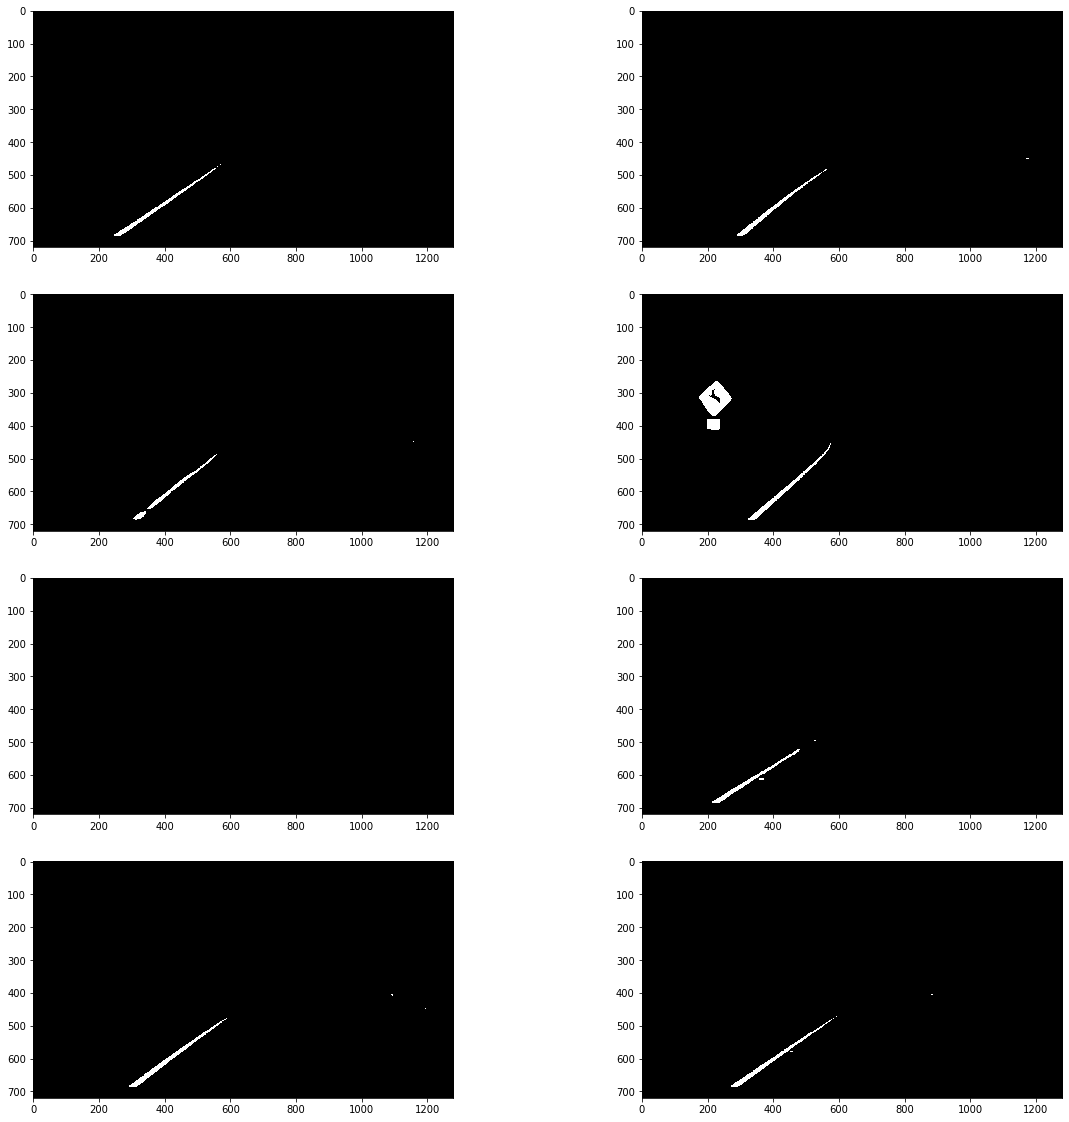

In [72]:
def b_lab_thresh(img, b_thresh=(0, 255)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    b_channel = lab[:,:,2]
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh[0]) & (b_channel < b_thresh[1])] = 1
    
    return b_binary

b_bin_list = []
for image in test_images:
    b_bin_list.append(b_lab_thresh(image, b_thresh=(170, 240)))
show_batch_grey(b_bin_list)

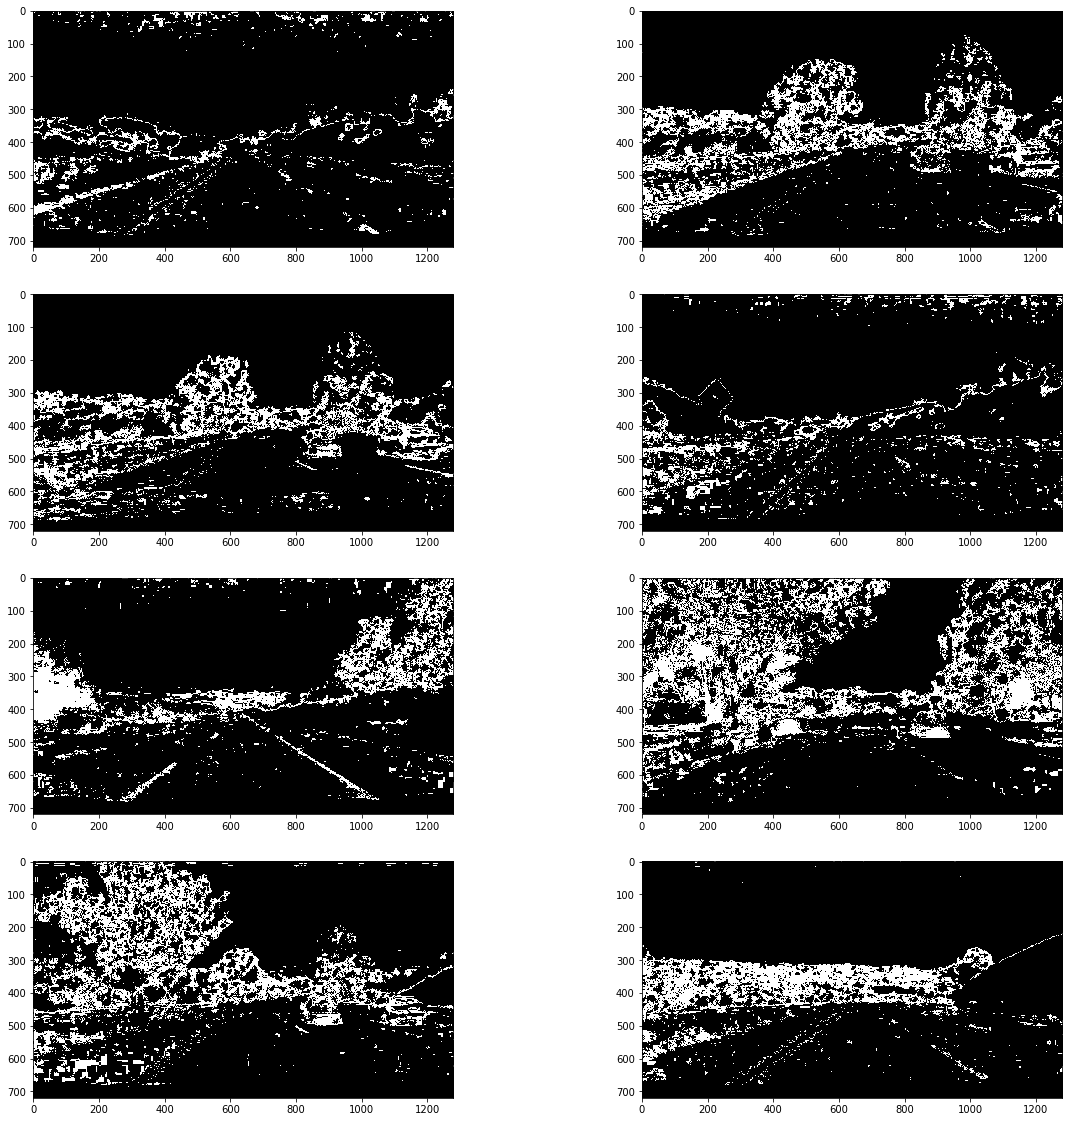

In [123]:
def a_lab_thresh(img, a_thresh=(0, 255)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    a_channel = lab[:,:,1]
    a_binary = np.zeros_like(a_channel)
    a_binary[(a_channel >= a_thresh[0]) & (a_channel < a_thresh[1])] = 1
    
    return a_binary

a_bin_list = []
for image in test_images:
    a_bin_list.append(a_lab_thresh(image, a_thresh=(127, 130)))
show_batch_grey(a_bin_list)

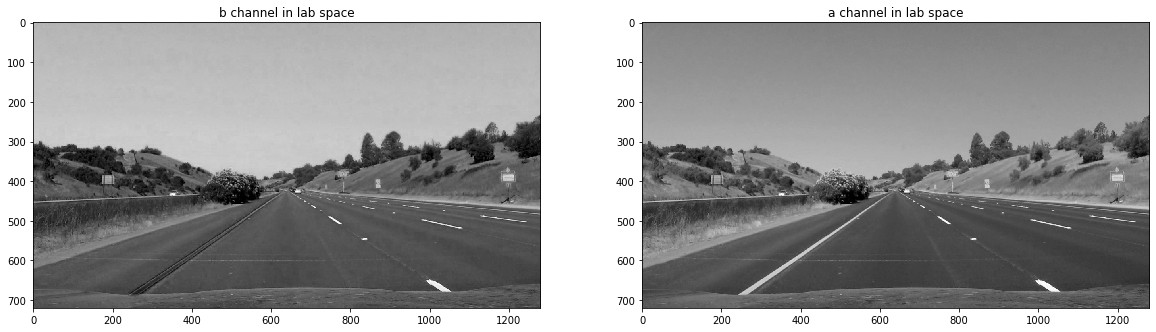

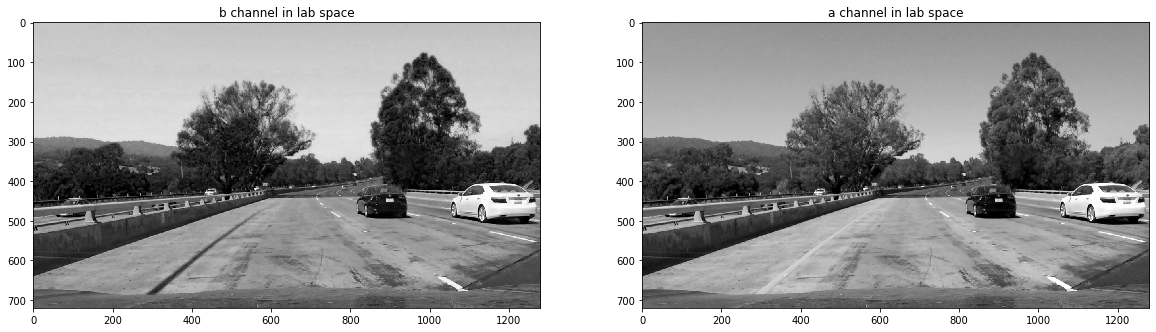

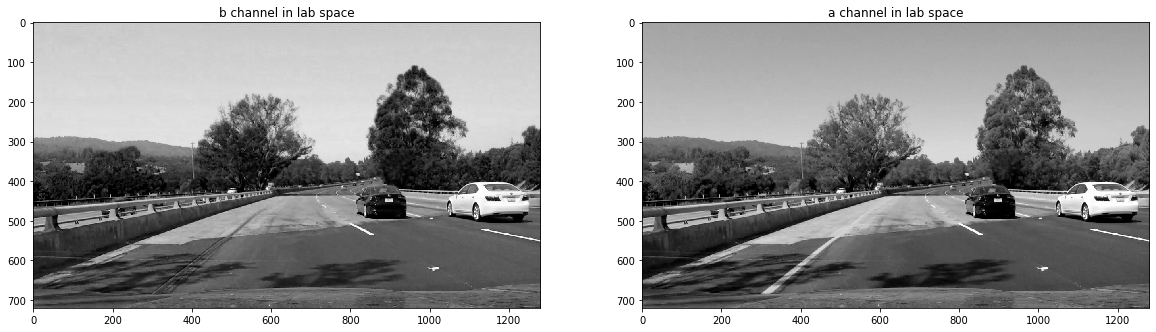

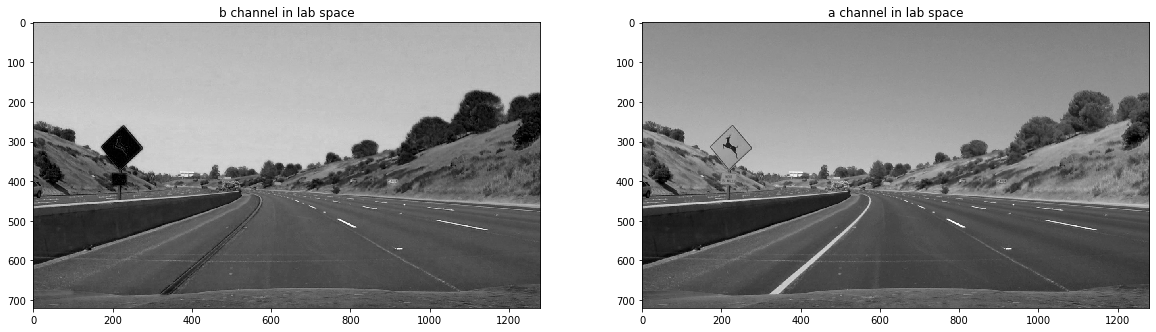

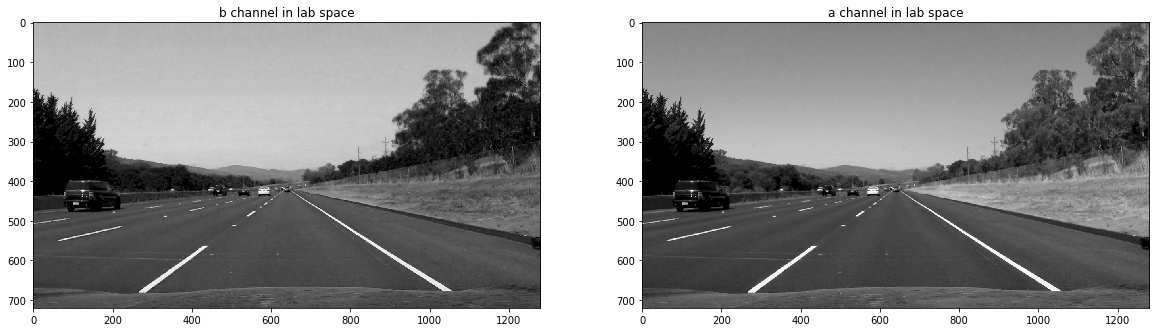

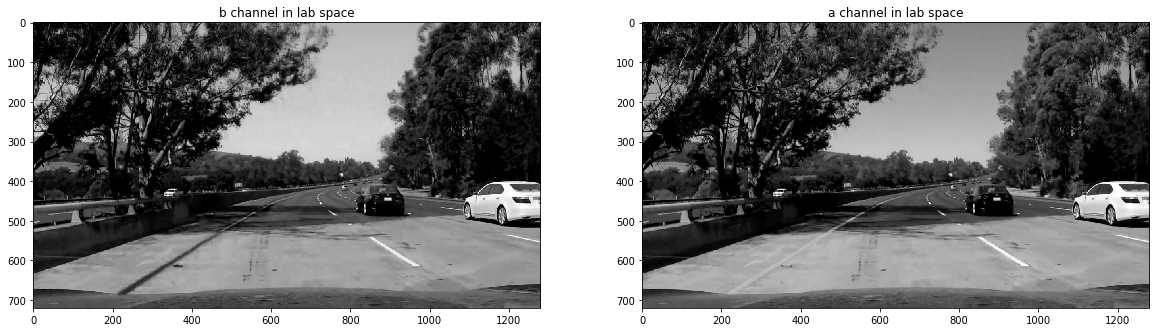

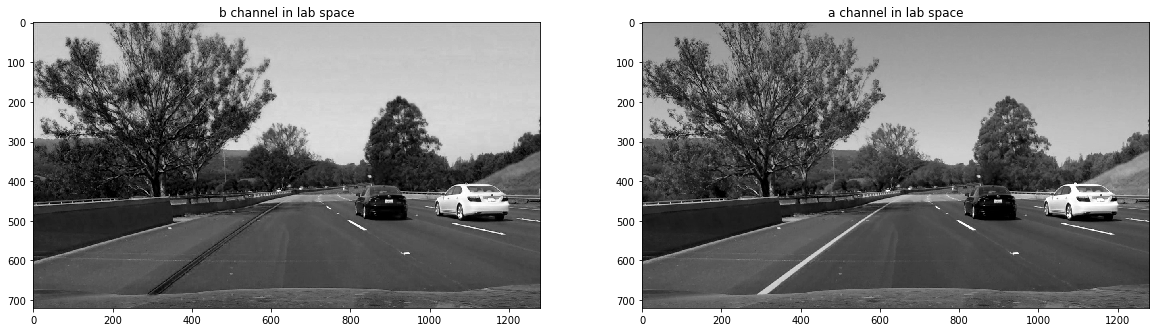

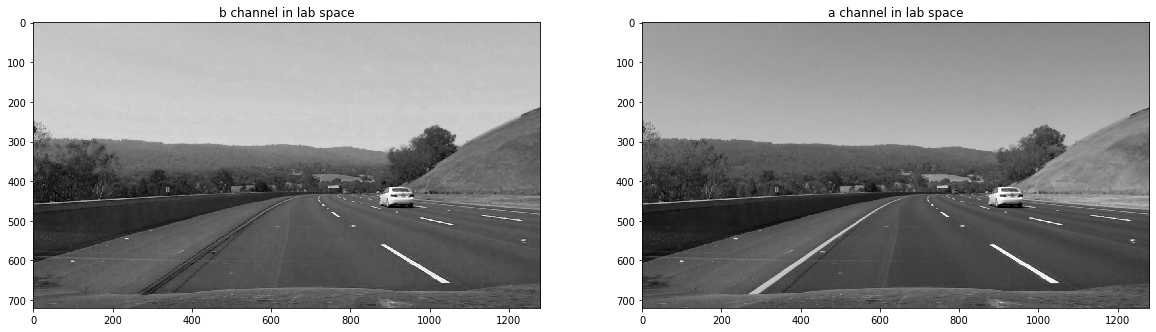

In [60]:
def lab_color(img, channel="b"):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    if channel == "l":
        output = img[:,:,0]
    elif channel == "a":
        output = img[:,:,1]
    elif channel == "b":
        output = img[:,:,2]
    
    return output

lab_list = []
for image in test_images:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 23))
    ax1.imshow(lab_color(image, channel="b"), cmap="gray")
    ax1.set_title("b channel in lab space")
    
    ax2.imshow(lab_color(image, channel="a"), cmap="gray")
    ax2.set_title("a channel in lab space")

In [ ]:
def hsv_color(img, channel="s"):
    img = np.copy(img)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    if channel == "s":
        output = hsv[:,:,1]
    elif channel == "h":
        output = hsv[:,:,0]
    elif channel == "v":
        output = hsv[:,:,2]
    
    return output

hsv_list = []
for image in test_images:
    hsv_list.append(hsl_color(image))
    
show_batch_grey(hsl_list)

In [ ]:
def hsl_color(img, channel="s"):
    img = np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel == "s":
        output = hls[:,:,2]
    elif channel == "h":
        output = hls[:,:,0]
    elif channel == "l":
        output = hls[:,:,1]
    
    return output

hsl_list = []
for image in test_images:
    hsl_list.append(hsl_color(image, channel="l"))
    
show_batch_grey(hsl_list)

In [ ]:
# compare s channel in hsl with v channel in hsv on test images
def compare(img_list):
    for img in img_list:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()

        ax1.imshow(s_hsl_thresh(img, (170, 255)), cmap='gray')
        ax1.set_title('s_hsl_thresh', fontsize=40)

        ax2.imshow(v_hsv_thresh(img, (215, 255)), cmap='gray')
        ax2.set_title('v_hsv_thresh', fontsize=40)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

compare(test_images)

In [10]:
# define gradient threshold functions
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient direction
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # scale 
    scaled_sobel = np.abs(np.uint8(255*sobel/np.max(sobel)))
    # Apply threshold
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel <= thresh[1]) & (scaled_sobel >= thresh[0])] = 1
    
    return grad_binary

def h_mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # calculate gradient magnitude
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag_sobel = np.sqrt(np.square(sobelX) + np.square(sobelY))
    # scale
    scaled_mag = np.uint8(255*mag_sobel/np.max(mag_sobel))
    # apply threshold
    mag_binary = np.zeros_like(scaled_mag)
    mag_binary[(scaled_mag >= thresh[0]) & (scaled_mag <= thresh[1])] = 1
    
    return mag_binary

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # calculate gradient direction
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    dir_sobel = np.arctan2(np.abs(sobelY), np.abs(sobelX))
    # apply threshold
    dir_binary = np.zeros_like(dir_sobel)
    dir_binary[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])] = 1

    return dir_binary

In [ ]:
# compare x dir grad and  y dir grad on test images

for image in test_images:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(abs_sobel_thresh(image, orient='x', sobel_kernel=9, thresh=(10, 80)), cmap='gray')
    ax1.set_title('sobel_x', fontsize=40)

    ax2.imshow(abs_sobel_thresh(image, orient='y', sobel_kernel=9, thresh=(20, 90)), cmap='gray')
    ax2.set_title('sobel y', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



In [ ]:
# compare x dir grad and  y dir grad on test images

for image in test_images:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(abs_sobel_thresh(image, orient='x', sobel_kernel=5, thresh=(30, 100)), cmap='gray')
    ax1.set_title('sobel_x', fontsize=40)

    ax2.imshow(abs_sobel_thresh(image, orient='y', sobel_kernel=5, thresh=(30, 100)), cmap='gray')
    ax2.set_title('sobel y', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



In [ ]:
# compare mag grad and  dir grad on test images

for image in test_images:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(h_mag_thresh(image, sobel_kernel=5, thresh=(30, 150)), cmap='gray')
    ax1.set_title('h_mag_thresh', fontsize=40)

    ax2.imshow(dir_thresh(image, sobel_kernel=5, thresh=(0.7, 1.2)), cmap='gray')
    ax2.set_title('dir_thresh', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



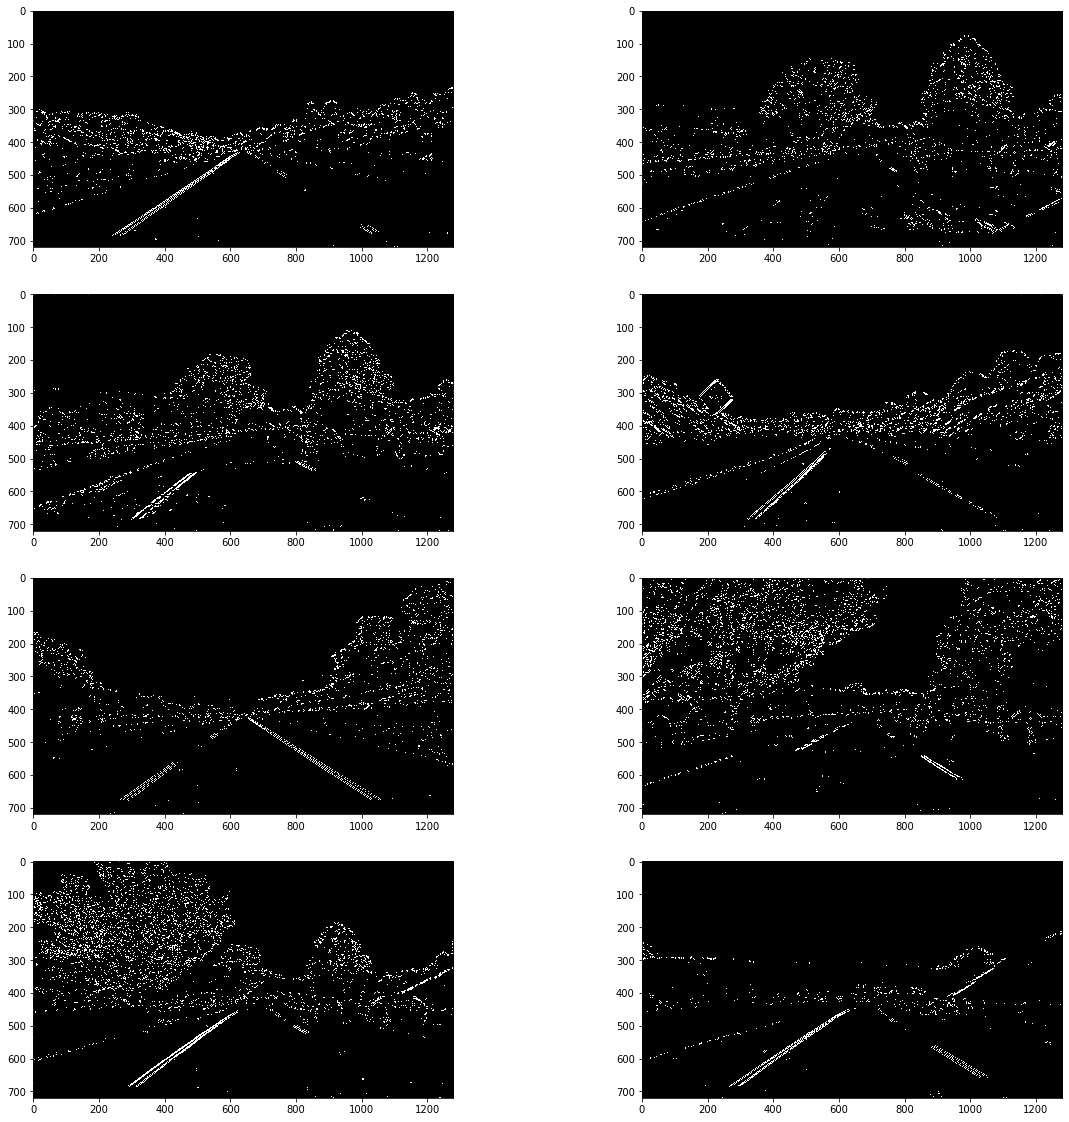

In [11]:
ksize = 9

def comb_grad(img):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(10, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(10, 100))
    mag_binary = h_mag_thresh(img, sobel_kernel=ksize, thresh=(30, 150))
    dir_binary = dir_thresh(img, sobel_kernel=ksize, thresh=(0.7, 1.2))


    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) | (grady == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1
#     combined[((gradx == 1) | (grady == 1)) ] = 1 # norm
#    combined[((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

comb_grad_list = []
for image in test_images:
    comb_grad_list.append(comb_grad(image))

show_batch_grey(comb_grad_list)

### final threshold

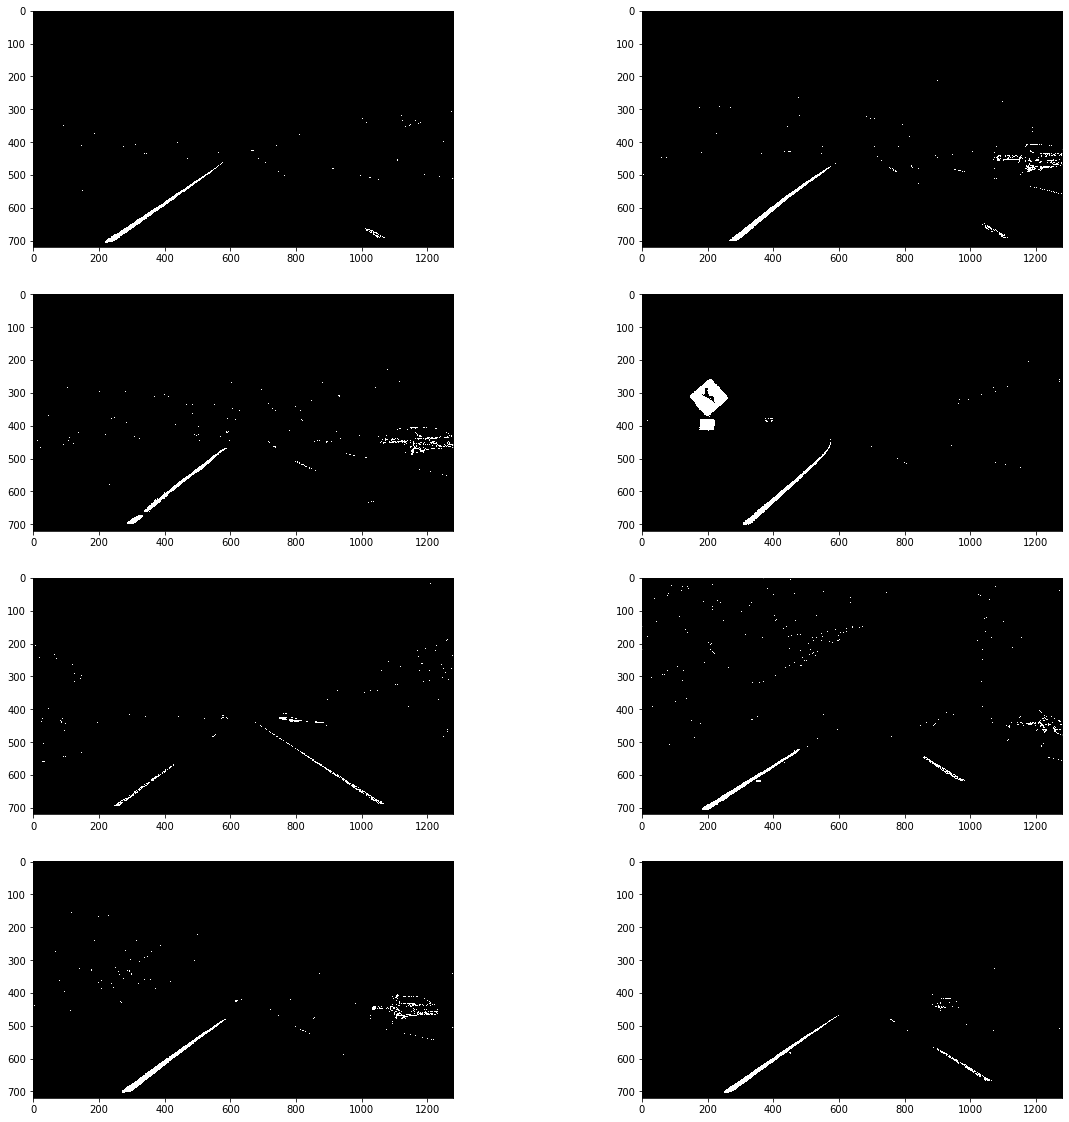

In [88]:
def threshold(img):
    v_hsv = v_hsv_thresh(img, (215, 255))
    s_hsl = s_hsl_thresh(img, (155, 255))
    b_lab = b_lab_thresh(img, (170, 240))
    grad = comb_grad(img)
    combined = np.zeros_like(v_hsv)
    
    combined[((v_hsv == 1) & (s_hsl == 1)) |
            ((v_hsv == 1) & (grad == 1)) |
            ((s_hsl == 1) & (grad == 1)) |
            (b_lab == 1)] = 1
    return combined
# use combined threshold
threshold_list = []
for image in udist_list:
    threshold_list.append(threshold(image))
show_batch_grey(threshold_list)

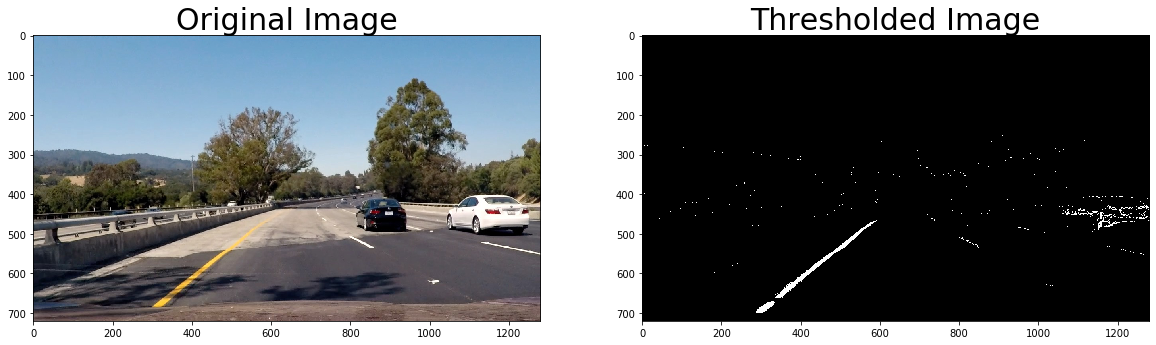

In [90]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_images[2])
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(threshold_list[2], cmap="gray")
ax2.set_title('Thresholded Image', fontsize=30)
plt.savefig("Thresholded.png")

### perspective transform 

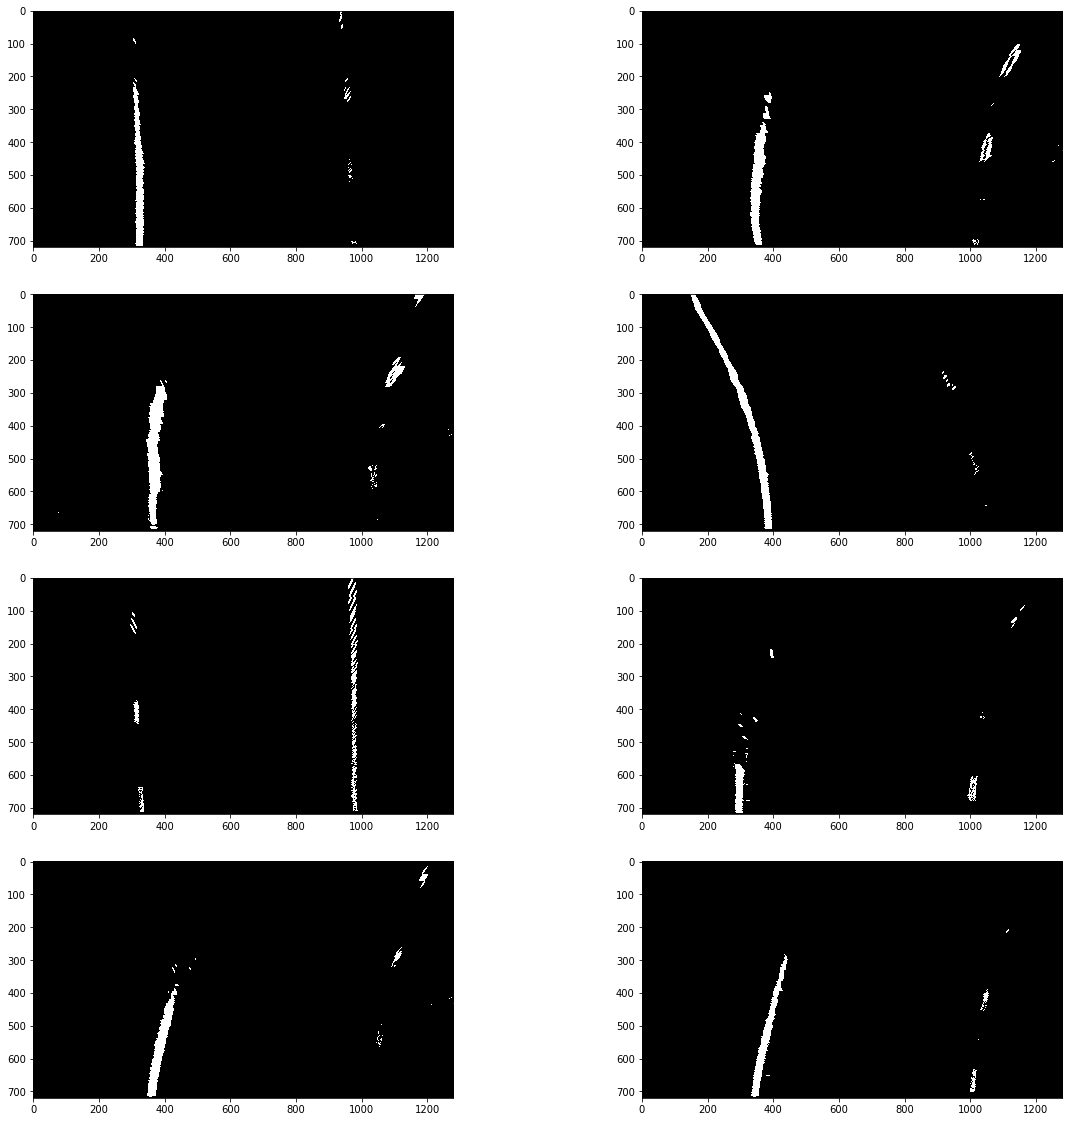

In [91]:
# use perspective transform
warped_cal_list = []
for image in threshold_list:
    warped, M = warp_undistorted(image) 
    warped_cal_list.append(warped)
show_batch_grey(warped_cal_list)

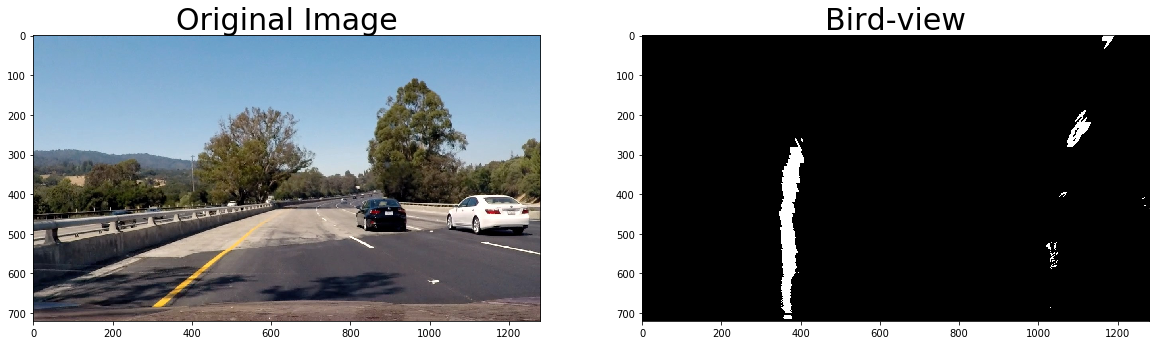

In [92]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_images[2])
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped_cal_list[2], cmap="gray")
ax2.set_title('Bird-view', fontsize=30)
plt.savefig("bird.png")

### find line

In [93]:
def find_lines(img):
    # split histogram into left and right
    # create histogram
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)

    # create output img
    out_img = np.dstack((img, img, img))*255

    # find left and right pead on hist
    mid_p = np.int(hist.shape[0]//2)
    # first poinst of the lines
    leftx_base = np.argmax(hist[0:mid_p])
    rightx_base = np.argmax(hist[mid_p:]) + mid_p

    # sliding window hyperparams
    # number of the sliding windows
    n_windows = 9
    # width is +/- margin
    margin = 100
    # min number of pixels to recenter window
    minpix = 50

    # set window height
    h_window = np.int(img.shape[0]//n_windows)
    # indentify all non zero pixels and split x and y
    nonzero = img.nonzero()
    #print(f'nonzero len is {len(nonzero)}')
    #print(nonzero)
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    # start current pos 
    leftx_cur = leftx_base
    rightx_cur = rightx_base

    # left and right index list to receive lane pixels
    left_lane_inds = []
    right_lane_inds = []

    for window in range(n_windows):
        win_low_y = img.shape[0] - (window + 1) * h_window
        win_high_y = img.shape[0] - (window) * h_window
        win_left_low_x = leftx_cur - margin
        win_left_high_x = leftx_cur + margin
        win_right_low_x = rightx_cur - margin
        win_right_high_x = rightx_cur + margin
        
        # find nonzero indexes in windows
        good_left_inds = ((nonzeroy >= win_low_y) & (nonzeroy < win_high_y) &
                          (nonzerox >= win_left_low_x) & (nonzerox < win_left_high_x)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_low_y) & (nonzeroy < win_high_y) &
                           (nonzerox >= win_right_low_x) & (nonzerox < win_right_high_x)).nonzero()[0]

        # append inds to the lines
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # recented window if  many pixels
        if len(good_left_inds) > minpix:
                leftx_cur = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
                rightx_cur = np.int(np.mean(nonzerox[good_right_inds]))

    # concat array of indices
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    # find left and right pixel poses
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty 

In [94]:
def find_poly(img_shape, linex, liney):
    # find coefficient for curv throught lane points
    fit = np.polyfit(liney, linex, 2) # x, y and polinome power
    # generate y points for plotting the line
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0]) # from, to, number of points
    # calculate points of  polinominals 
    try:
        polx = fit[0] * ploty**2 + fit[1] * ploty + fit[2]
    except TypeError:
        # Avoids an error if `fit` are still none or incorrect
        print('The function failed to fit a line!')
        polx = 1*ploty**2 + 1*ploty
        
    return fit, polx, ploty

In [95]:
def draw_by_fit(bin_warped, left_fit, right_fit):
    # find numspace for drawing
    ploty = np.linspace(0, bin_warped.shape[0]-1, bin_warped.shape[1])
    # calculate points of polynominal
    try:
        left_polx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_polx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_polx = 1*ploty**2 + 1*ploty
        right_polx = 1*ploty**2 + 1*ploty
        
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(bin_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_polx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_polx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    return color_warp    

In [96]:
def draw_poly_bin(binary_warped, left_fitx, right_fitx, ploty, show_search=False, margin=100):
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    result = out_img
    if show_search == True:
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='red')
    plt.plot(right_fitx, ploty, color='red')
    ## End visualization steps ##
       
    return result

In [97]:
def search_near_poly(bin_img, left_polx, right_polx):
    #define margin (wide of the tube around polyline)
    margin = 80
    
    # take nonzero (ie 1 in bin image) pixels
    nonzero = bin_img.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    # define area for search poly +/- margin
    left_lin_inds = ((nonzerox > (left_polx[0]*(nonzeroy**2) + 
                                  left_polx[1]*nonzeroy + left_polx[2] - margin)) &
                     (nonzerox < (left_polx[0]*(nonzeroy**2) + 
                                  left_polx[1]*nonzeroy + left_polx[2] + margin)))
    right_lin_inds = ((nonzerox > (right_polx[0]*(nonzeroy**2) + 
                                   right_polx[1]*nonzeroy + right_polx[2] - margin)) &
                     (nonzerox < (right_polx[0]*(nonzeroy**2) + 
                                   right_polx[1]*nonzeroy + right_polx[2] + margin)))
    # find left and right pixel poses
    leftx = nonzerox[left_lin_inds]
    lefty = nonzeroy[left_lin_inds]
    rightx = nonzerox[right_lin_inds]
    righty = nonzeroy[right_lin_inds]
    
    return leftx, lefty, rightx, righty

### measure curvature and car position

In [98]:
def measure_curv(img_shape, x, y):
    # define pixel to meters conversion coefficienst
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # find poly coef in meters
    fit_meters = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    # find lin space for polynominal
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # set point there we want to measure curvature
    # It is bottom of the image because there is our camera on birdview
    y_eval = np.max(ploty)
    # convert eval point form pixels to meters
    y_eval_m = y_eval * ym_per_pix
    
    curvrad = ((1 + (2*fit_meters[0]*y_eval_m + fit_meters[1])**2)**1.5) / np.abs(2*fit_meters[0])

    return curvrad


def measure_pose(img, left_fit, right_fit, ploty): 
    # calculate
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    car_pos = img.shape[1] / 2 * xm_per_pix
    # It is bottom of the image because there is our camera on birdview
    y_eval = np.max(ploty)
    # calculate center of the lane
    left_fpoint = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_fpoint = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    #calculate car pose
    lane_center = (right_fpoint + left_fpoint) / 2 * xm_per_pix
    pose = lane_center - car_pos
        
    return pose

13592
left_coef [ 2.46857164e-04 -2.83973595e-01  4.46714949e+02]
left curvrd is 665.351218290529, right curvrd is 731.199508886915


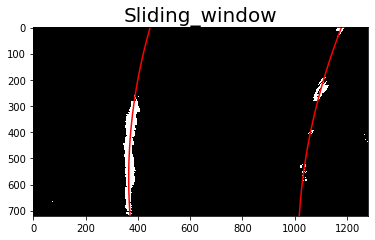

In [99]:
use_img = warped_cal_list[2]
leftx, lefty, rightx, righty = find_lines(use_img)
print(len(leftx))
#left line
left_coef, left_polx, left_poly = find_poly(use_img.shape, leftx, lefty)
print(f"left_coef {left_coef}")
right_coef, right_polx, right_poly = find_poly(use_img.shape, rightx, righty)
img_show = draw_poly_bin(use_img, left_polx, right_polx, right_poly)
leftcurvrd = measure_curv(use_img.shape, leftx, lefty)
rightcurvrd = measure_curv(use_img.shape, rightx, righty)
print(f"left curvrd is {leftcurvrd}, right curvrd is {rightcurvrd}")
# plt.figure(figsize=(20,10))
plt.title("Sliding_window", fontsize=20)
plt.imshow(img_show)
plt.savefig("window.png")

[480 481 481 481 482 482 482 483 483 483 484 484 484 484 485 485 485 485
 485 486 486 486 486 486 487 487 487 487 488 489 489 489 489 490 490 490
 490 490 491 491 491 491 491 492 492 492 492 492 492 493 493 493 493 493
 493 493 494 494 494 494 494 494 494 494 495 495 495 495 495 495 495 496
 496 496 496 497 497 497 498 498 499 500 501 501 502 502 504 504 505 505
 505 506 507 508 508 509 509 510 511 511 512 512 512 512 512 513 513 513
 513 513 514 514 514 514 514 514 515 515 515 515 515 515 515 516 516 516
 516 516 516 516 517 517 517 517 517 517 517 517 518 518 519 519 519 520
 521 522 522 523 524 525 525 526 526 526 527 527 527 527 528 528 528 528
 529 529 529 529 529 529 530 530 530 530 530 530 530 530 531 531 531 531
 531 531 531 531 531 531 532 532 532 532 532 532 532 532 532 532 533 533
 533 533 533 533 533 533 533 534 534 534 534 534 534 534 534 534 534 535
 535 535 535 535 535 535 535 536 537 537 538 538 538 539 539 539 539 539
 539 539 539 540 540 540 540 540 540 540 540 540 54

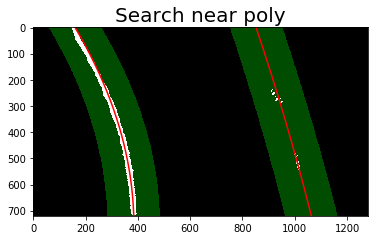

In [100]:
use_img1 = warped_cal_list[3]
leftx1, lefty1, rightx1, righty1 = search_near_poly(use_img1, left_coef, right_coef)
print(righty1)
left_coef1, left_polx1, left_poly1 = find_poly(use_img.shape, leftx1, lefty1)
print(f"left_coef1 is {left_coef1}")
right_coef1, right_polx1, right_poly1 = find_poly(use_img.shape, rightx1, righty1)
img_show1 = draw_poly_bin(use_img1, left_polx1, right_polx1, right_poly1, show_search=True)
leftcurvrd1 = measure_curv(use_img1.shape, leftx1, lefty1)
rightcurvrd1 = measure_curv(use_img1.shape, rightx1, righty1)
print(f"left curvrd is {leftcurvrd1}, right curvrd is {rightcurvrd1}")
plt.title("Search near poly", fontsize=20)
plt.imshow(img_show1)
plt.savefig("search_near.png")

### make pipeline

In [104]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):    
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        self.restart()
    
    def restart(self):
        # line was found in previous image
        self.was_detected = False
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # list of last 5 poly coefficients
        self.last_five_fits = []
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        # current curv pounts
        self.polx = None
        # current ploty
        self.ploty = None
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None  
        # counter for false detection
        self.count = 0
        
    def add_fit(self, fit):
        self.current_fit = fit
        if len(self.last_five_fits) < 5:
            self.last_five_fits.append(fit)
        elif len(self.last_five_fits) == 5:
            self.last_five_fits.pop(0)
            self.last_five_fits.append(fit)
    
    # counter for false detection
    # if more, restart the line
    def count_check(self):
        if self.count > 5:
            self.restart()
            
            
    def find_best_fit(self):
        self.best_fit = np.mean(self.last_five_fits, axis=0)
        return self.best_fit

# load distortion parameters
dist_pickle = pickle.load( open( "car_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

#init lines
left_line = Line()
right_line = Line()

def pipeline(img, mtx, dist):
    #undistort image
    undisted = undist(img, mtx, dist)
    # apply combined color and gradient threshold
    tresh = threshold(undisted)
    # change persperctine to birdview
    warped_thresh, M = warp_undistorted(tresh)
    left_line.count_check()
    right_line.count_check()
    # if we have not lines use sliding window
    if left_line.was_detected is False or right_line.was_detected is False:
        # find points of lines by sliding window
        leftx, lefty, rightx, righty = find_lines(warped_thresh)
    # if we already have lines from previous image 
    elif left_line.was_detected is True and right_line.was_detected is True:
        # use search near poly
        leftx, lefty, rightx, righty = search_near_poly(warped_thresh, 
                                                             left_line.current_fit, right_line.current_fit)
   # if find points of the right line
    if len(rightx) > 0 and len(righty) > 0:
        # set was detected
        right_line.was_detected = True
        # add founded points to instanse
        right_line.allx = rightx
        right_line.ally = righty
        # add poly 
        l_fit, right_line.polx, right_line.ploty = find_poly(warped_thresh.shape,right_line.allx, right_line.ally)
        right_line.add_fit(l_fit)
    else:
        right_line.count += 1 
    # if find points of left line
    if len(leftx) > 0 and len(lefty) > 0:
        # set was detected
        left_line.was_detected = True
        # add founded points to instanse
        left_line.allx = leftx
        left_line.ally = lefty
        # add poly 
        r_fit, left_line.polx, left_line.ploty = find_poly(warped_thresh.shape,left_line.allx, left_line.ally)
        left_line.add_fit(r_fit)
    else:
        left_line.count += 1

    # measure curvature 
    left_curvrd = measure_curv(warped_thresh.shape, left_line.allx, left_line.ally)
    right_curvd = measure_curv(warped_thresh.shape, right_line.allx, right_line.ally)
    avg_curvrd = round(np.mean([left_curvrd,right_curvd]), 0)
    curv_text = f"current radius of  curvature is {avg_curvrd} meters"
    # measure car position on the road
    car_pose = measure_pose(warped_thresh,left_line.current_fit, right_line.current_fit, left_line.ploty)
    if car_pose > 0:
        pose_text = f"car is {round(abs(car_pose), 2)} meters left from center"
    else:
        pose_text = f"car is {round(abs(car_pose), 2)} meters right from center"
        
    # print test to image   
    font = cv2.FONT_HERSHEY_PLAIN
    cv2.putText(undisted, curv_text, (10,100), font, 1, (255,255,255), 2)
    cv2.putText(undisted, pose_text, (10,150), font, 1, (255,255,255), 2)
    
    #Draving lines
    # invert matrix of tranfer
    Minv = np.linalg.inv(M)
    # find best fits  for drawing
    left_line.find_best_fit()
    right_line.find_best_fit()
    color_warp = draw_by_fit(warped_thresh, left_line.best_fit, right_line.best_fit)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undisted, 1, newwarp, 0.3, 0)
    
    return result

### video processing

In [102]:
import imageio

imageio.plugins.ffmpeg.download

imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline(image, mtx, dist)
    return result

In [ ]:
output = 'project_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)